### Import Various Necessary Libraries Dask and Related Libraries

In [1]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import dask
import os
import sys
import uuid

### Add proxy binaries to path

In [2]:
pwd = !echo ${PWD}

### Extend the local python paths with some network drives

In [3]:
extension_python_paths = ['/datasets/work/oa-roamsurf/work/cmextremes_py/extraction/', os.environ["HOME"] + '/lib/python3.8/site-packages']
[sys.path.append(an_ext) for an_ext in extension_python_paths]

[None, None]

### Specify a python exe used by SLURM to create the dask workers


In [4]:
containered_python_exe = f"srun --export=ALL -n $SLURM_NTASKS -c $SLURM_CPUS_PER_TASK   singularity run {os.environ['SINGULARITY_CONTAINER']} python"

### If you run this cell after creating a cluster it will close that cluster 

In [5]:
try:
    cluster.close()
except:
    pass

### Create a cluster
env_extra sets the worker specific environment parameters   

PYTHONPATH is set to include the extension ptyhon paths and the SINGULARITY_BINDPATH bind paths of this jupyter environment for passing to the workers

In [6]:
job_suffix = os.environ['JOB_SUFFIX'] if 'JOB_SUFFIX' in os.environ.keys() else str(uuid.uuid4())[:8]

## List available project codes

In [7]:
!get_project_codes

/bin/bash: line 1: get_project_codes: command not found


In [8]:
# defined = 'NC_IN_GLOB' in os.environ.keys()
# if not defined:
#     print("WARNING, project code note defined defaulting")
#     project_code = 'OD-215204'
# else:
#     project_code = os.environ['NC_IN_GLOB']

# OD-229130	2023-12-31	Van KIRAP 2.0: GCF Vanuatu Climate Information Services for Resilient Development
project_code = 'OD-229130'

In [9]:
job_extra = f'--account {project_code}'

In [10]:
process_number = 2

In [11]:
cluster = SLURMCluster(
    cores=6, memory="180G", processes=process_number,
    walltime="02:00:00",
    interface='ib0',
    death_timeout=480,
    job_name = f'dask-worker-{job_suffix}',
    job_extra = [job_extra],
    env_extra=[
              'module load singularity', # ensure singularity is loaded
              'export PYTHONPATH=' + ':'.join(extension_python_paths),
              'export SINGULARITY_BINDPATH=' + os.environ['SINGULARITY_BIND'], 
              'export SINGULARITYENV_PREPEND_PATH='+ str(pwd[0]) +':' + str(pwd[0]) + ',/srv/conda/envs/notebook/bin:/srv/conda/condabin:/srv/conda/bin'],
    extra = [f'--local-directory={os.environ["SCRATCH3DIR"]}'],
    python=containered_python_exe,  # use pyhton in container
)

# Debug by running cluster.job_script()

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue

## if running a single process based cluster something like this might be needed
```
cluster = SLURMCluster(
    cores=1, memory="24G", processes=1,
    walltime="01:59:00",
    interface='ib0',
    death_timeout=480,
    nanny=False,
    job_name = f'dask-worker-{job_suffix}',
    job_extra = [job_extra],
    extra = [f' --local-directory={os.environ["SCRATCH2DIR"]}'],
    env_extra=[
    'module load singularity', # ensure singularity is loaded
    'export PYTHONPATH=' + ':'.join(extension_python_paths),
    'export SINGULARITY_BINDPATH=' + os.environ['SINGULARITY_BIND'],
    'export SINGULARITYENV_PREPEND_PATH='+ str(pwd[0]) +':' + str(pwd[0]) + ',/srv/conda/envs/notebook/bin:/srv/conda/condabin:/srv/conda/bin'],
    python=containered_python_exe, # use pyhton in container    
)
```

### Create a client, this will inject dask into xarray and the distributed cluster into dask

In [12]:
client = Client(cluster, timeout=240)
display(client)

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.150.202.157:45005/status,
Dashboard: http://10.150.202.157:45005/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.150.202.157:34401,Workers: 0
Dashboard: http://10.150.202.157:45005/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [13]:
port = client.dashboard_link.split('/')[-2].split(':')[-1]
print(f"Try http://localhost:8888/proxy/{port}/status for the dask dashboard")

Try http://localhost:8888/proxy/45005/status for the dask dashboard


### Scale your workers

With the default config in SLURMCluster above each job will get create 2 workers, one per process and each will have 30gb ram and 4 cores

In [14]:
max_workers = 10

import time
for i in range(0, max_workers): 
    cluster.scale(jobs=i) #yes this looks weird requesting n+1 workers everytime but really it only requests 1 new worker each time
    time.sleep(5)

timeout = 600   # seconds till timeout, timeout if cluster not up in 10 minutes
timeout_start = time.time()
while len(client.ncores().keys())*process_number < max_workers -1:
    if (time.time() > timeout_start+timeout):
        raise Exception(f"Failed to start enough workers in {timeout} seconds, {len(cluster.workers)} started")
    time.sleep(1)

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_jobqueue

In [15]:
len(client.ncores())

6

## Actual original notebook cells to do the work ...

In [16]:
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import re
import glob

/tmp/hoe01e.16909/ipykernel_13970/466678482.py:5: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [17]:
# # only run this if above dask cluster cells are notrun
# # comment out otherwise
# from dask.distributed import Client, LocalCluster 
# cluster = LocalCluster() # Launches a scheduler and workers locally 
# client = Client(cluster)

In [18]:
# get some pre-defined functions
# probably want to move them somewhere better more accessible
base_path = '/datasets/work/oa-vankirap/work/'
# scratch_path = '/scratch1/hoe01e/vankirap/'

sys.path.append(f'{base_path}/schism/bin/')
from SCHISM_load_plot_defs import schism_load, find_nearest_wet_point, schism_plot

In [19]:
# location of coastal points:
# coastpoints_gdf = pd.read_csv(f'{data_path}Vanuatu_TWL_points.csv',
#                               dtype={'index':np.int32, 'longitude':np.float32,'latitude':np.float32})
coastpoints_gdf=gpd.read_file(f'{base_path}TWL_calc/Vanuatu_TWL_points_v3.shp')

coastpoints_gdf = coastpoints_gdf.to_crs('EPSG:4326')
coastpoints_gdf = coastpoints_gdf.explode(index_parts=False, ignore_index=True)
coastpoints_gdf['longitude'] = coastpoints_gdf['geometry'].x
coastpoints_gdf['latitude'] = coastpoints_gdf['geometry'].y
coastpoints_gdf = coastpoints_gdf[['geometry','longitude','latitude']]
# empty column for SCHISM water levels:
# TWL = {}

coastpoints_gdf

,geometry,longitude,latitude
0,POINT (169.77335 -20.24719),169.773350,-20.247186
1,POINT (169.77055 -20.25033),169.770549,-20.250329
2,POINT (169.77335 -20.24719),169.773350,-20.247186
3,POINT (169.79354 -20.23639),169.793537,-20.236394
4,POINT (169.79907 -20.23833),169.799074,-20.238329
...,...,...,...
2372,POINT (166.55624 -13.10209),166.556237,-13.102088
2373,POINT (166.55465 -13.09901),166.554650,-13.099013
2374,POINT (166.54917 -13.08943),166.549171,-13.089432
2375,POINT (166.54562 -13.08430),166.545624,-13.084301


In [20]:
# sc_2016, meshtri = schism_load(f'{base_path}/schism/Hindcast_v2/schout_2015_elev_hs.nc')
# sc_2016 = xr.open_dataset(f'{base_path}/schism/Hindcast_v2/schout_2015_elev_hs.nc', chunks={'time': 8760/8})
# sc_ds = xr.open_mfdataset(f'{base_path}/schism/Hindcast_v2/schout_*_elev_hs.nc', chunks={'time': 8760/2, })
files = glob.glob(f'{base_path}/schism/Hindcast_v3/schout_*_elev_hs.nc')
# files = glob.glob(f'{scratch_path}/Hindcast_v3/schout_*_elev_hs.nc')
# sc_ds = xr.open_mfdataset(files[0:3], chunks='auto')
sc_ds = xr.open_mfdataset(files, chunks='auto')
for var in ['SCHISM_hgrid_face_nodes','SCHISM_hgrid_node_x','SCHISM_hgrid_node_y','depth']:
    sc_ds[var]=sc_ds[var].isel(time=0)

In [21]:
sc_ds

<xarray.Dataset>
Dimensions:                  (time: 359424, nSCHISM_hgrid_node: 100927,
                              nSCHISM_hgrid_face: 201374,
                              nMaxSCHISM_hgrid_face_nodes: 4, one: 1)
Coordinates:
  * time                     (time) datetime64[ns] 1980-01-01T01:00:00 ... 20...
Dimensions without coordinates: nSCHISM_hgrid_node, nSCHISM_hgrid_face,
                                nMaxSCHISM_hgrid_face_nodes, one
Data variables:
    elev                     (time, nSCHISM_hgrid_node) float32 dask.array<chunksize=(1708, 19644), meta=np.ndarray>
    hs                       (time, nSCHISM_hgrid_node) float32 dask.array<chunksize=(1708, 19644), meta=np.ndarray>
    SCHISM_hgrid_face_nodes  (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) float64 dask.array<chunksize=(201374, 4), meta=np.ndarray>
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float64 dask.array<chunksize=(100927,), meta=np.ndarray>
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float64 dask.array<chunksize=(100927,), meta=np.ndarray>
    depth                    (nSCHISM_hgrid_node) float32 dask.array<chunksize=(100927,), meta=np.ndarray>
    minimum_depth            (time, one) float32 dask.array<chunksize=(8784, 1), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0, UGRID-1.0
    title:         SCHISM Model output
    institution:   SCHISM Model output
    source:        SCHISM model output version v10
    references:    http://ccrm.vims.edu/schismweb/
    history:       created by combine_output11
    comment:       SCHISM Model output
    type:          SCHISM Model output
    VisIT_plugin:  https://schism.water.ca.gov/library/-/document_library/vie...

In [22]:
sc_topo=sc_ds[['SCHISM_hgrid_node_x','SCHISM_hgrid_node_y', 'depth']]

In [23]:
# ds_temp, meshtri = schism_load(files[0])
# # ds_temp['minimum_depth']=np.asarray([0.01])
# # schism_plot(ds_temp, meshtri,'depth',varscale=[-500,0], pscale=10,project=False)
# import matplotlib.pyplot as plt
# plt.tripcolor(meshtri, ds_temp.depth)
# plt.colorbar()

In [24]:
# test_points = coastpoints_gdf[['longitude','latitude']][5:26]

In [25]:
# idxs = []
# kns = []
# for lon, lat in test_points.values:
#     idx,kn = find_nearest_wet_point(sc_topo,lon,lat)
#     idxs.append(idx)
#     kns.append(kn)

In [26]:
# sc_topo_cs=sc_topo.isel(nSCHISM_hgrid_node=idxs)

In [27]:
# test_points['node_idx'] = idxs
# test_points['kns'] = kns
# test_points['node_lons'] = sc_topo_cs.SCHISM_hgrid_node_x.values
# test_points['node_lats'] = sc_topo_cs.SCHISM_hgrid_node_y.values
# test_points['depth'] = sc_topo_cs.depth.values
# test_points.to_csv(f'{base_path}/TWL_calc/test_points_temp.csv')

In [28]:
# # test_points['elev']=sc_ds.elev.isel(nSCHISM_hgrid_node=idxs)
# test_points_ds=test_points.to_xarray()
# test_points_ds['elev']=sc_ds.elev.isel(nSCHISM_hgrid_node=idxs).rename({'nSCHISM_hgrid_node':'index'})
# test_points_ds

In [29]:
idxs = []
kns = []
for lon, lat in coastpoints_gdf[['longitude','latitude']].values:
    # try:
    idx,kn = find_nearest_wet_point(sc_topo,lon,lat)
    # except:
    #     print(f'Error in {lon}, {lat} ... inserting NaNs')
    #     # print(len(kn))
    #     print(kn)
    #     idx,kn = np.NaN, np.NaN
    idxs.append(idx)
    kns.append(kn)

*** Warning, more than one point found with equally deep depths (z = -0.0), defauling to first point
*** Warning, more than one point found with equally deep depths (z = -0.0), defauling to first point
*** Warning, more than one point found with equally deep depths (z = -4.0), defauling to first point
*** Warning, more than one point found with equally deep depths (z = -4.0), defauling to first point
*** Warning, more than one point found with equally deep depths (z = -0.0), defauling to first point
*** Warning, more than one point found with equally deep depths (z = -0.5), defauling to first point
*** Warning, more than one point found with equally deep depths (z = -0.5), defauling to first point
*** Warning, more than one point found with equally deep depths (z = -0.5), defauling to first point
*** Warning, more than one point found with equally deep depths (z = -0.0), defauling to first point
*** Warning, more than one point found with equally deep depths (z = -0.0), defauling to fi

In [30]:
sc_topo_cs=sc_topo.isel(nSCHISM_hgrid_node=idxs)

In [31]:
coastpoints_gdf_check = coastpoints_gdf
coastpoints_gdf_check['node_idx'] = idxs
coastpoints_gdf_check['kns'] = kns
coastpoints_gdf_check['node_lons'] = sc_topo_cs.SCHISM_hgrid_node_x.values
coastpoints_gdf_check['node_lats'] = sc_topo_cs.SCHISM_hgrid_node_y.values
coastpoints_gdf_check['depth'] = sc_topo_cs.depth.values

In [32]:
coastpoints_gdf_check

,geometry,longitude,latitude,node_idx,kns,node_lons,node_lats,depth
0,POINT (169.77335 -20.24719),169.773350,-20.247186,97728,5,169.77207,-20.24632,1.110000
1,POINT (169.77055 -20.25033),169.770549,-20.250329,97735,10,169.77167,-20.25469,0.370000
2,POINT (169.77335 -20.24719),169.773350,-20.247186,97728,5,169.77207,-20.24632,1.110000
3,POINT (169.79354 -20.23639),169.793537,-20.236394,97922,10,169.79625,-20.23786,0.000000
4,POINT (169.79907 -20.23833),169.799074,-20.238329,97922,10,169.79625,-20.23786,0.000000
...,...,...,...,...,...,...,...,...
2372,POINT (166.55624 -13.10209),166.556237,-13.102088,3282,10,166.55187,-13.10117,26.200001
2373,POINT (166.55465 -13.09901),166.554650,-13.099013,3238,10,166.54969,-13.09718,24.120001
2374,POINT (166.54917 -13.08943),166.549171,-13.089432,3210,10,166.54820,-13.09304,7.080000
2375,POINT (166.54562 -13.08430),166.545624,-13.084301,3141,10,166.54499,-13.09000,19.889999


In [33]:
coastpoints_gdf_check.to_csv(f'{base_path}/schism/EVA/Hindcast_v3_coastal_points_schism_nearest_wet_points_compare_v2.csv')

In [34]:
coastpoints_ds=coastpoints_gdf_check.to_xarray()
coastpoints_ds['elev']=sc_ds.elev.isel(nSCHISM_hgrid_node=idxs).rename({'nSCHISM_hgrid_node':'index'})
coastpoints_ds

<xarray.Dataset>
Dimensions:    (index: 2377, time: 359424)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 ... 2371 2372 2373 2374 2375 2376
  * time       (time) datetime64[ns] 1980-01-01T01:00:00 ... 2021-01-01
Data variables:
    geometry   (index) object POINT (169.77335013923894 -20.24718627443788) ....
    longitude  (index) float64 169.8 169.8 169.8 169.8 ... 166.5 166.5 166.5
    latitude   (index) float64 -20.25 -20.25 -20.25 ... -13.09 -13.08 -13.07
    node_idx   (index) int64 97728 97735 97728 97922 ... 3238 3210 3141 3164
    kns        (index) int64 5 10 5 10 10 10 10 5 5 ... 10 10 10 5 10 10 10 10 5
    node_lons  (index) float64 169.8 169.8 169.8 169.8 ... 166.5 166.5 166.5
    node_lats  (index) float64 -20.25 -20.25 -20.25 ... -13.09 -13.09 -13.07
    depth      (index) float32 1.11 0.37 1.11 0.0 0.0 ... 24.12 7.08 19.89 2.71
    elev       (time, index) float32 dask.array<chunksize=(1708, 6), meta=np.ndarray>

In [35]:
coastpoints_ds=coastpoints_ds.drop('geometry')
coastpoints_ds.elev.attrs['missing_value'] = np.nan

In [36]:
coastpoints_ds.elev.encoding = {}

In [38]:
coastpoints_ds.load().to_netcdf(f'{base_path}/schism/EVA/Hindcast_v3_coastal_points_schism_elev.nc')

In [39]:
coastpoints_ds

<xarray.Dataset>
Dimensions:    (index: 2377, time: 359424)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 ... 2371 2372 2373 2374 2375 2376
  * time       (time) datetime64[ns] 1980-01-01T01:00:00 ... 2021-01-01
Data variables:
    longitude  (index) float64 169.8 169.8 169.8 169.8 ... 166.5 166.5 166.5
    latitude   (index) float64 -20.25 -20.25 -20.25 ... -13.09 -13.08 -13.07
    node_idx   (index) int64 97728 97735 97728 97922 ... 3238 3210 3141 3164
    kns        (index) int64 5 10 5 10 10 10 10 5 5 ... 10 10 10 5 10 10 10 10 5
    node_lons  (index) float64 169.8 169.8 169.8 169.8 ... 166.5 166.5 166.5
    node_lats  (index) float64 -20.25 -20.25 -20.25 ... -13.09 -13.09 -13.07
    depth      (index) float32 1.11 0.37 1.11 0.0 0.0 ... 24.12 7.08 19.89 2.71
    elev       (time, index) float32 -0.2643 -0.248 ... -0.04502 -0.04967

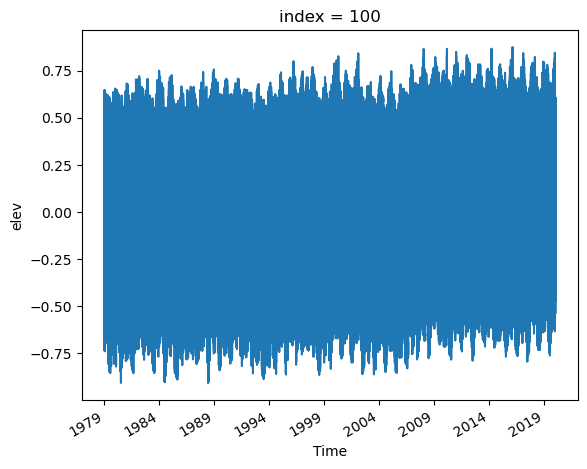

In [40]:
coastpoints_ds.isel(index=100).elev.plot()

In [ ]:
# coastpoints_eva_df = coastpoints_gdf.drop('geometry', axis=1)
# return_period = [10, 50, 100]
# dist_params = ['c', 'loc', 'scale']
# nan_col = np.ones(len(idxs))*np.nan
# for col in ['thres']+dist_params:
#     coastpoints_eva_df[col]=nan_col
# for rt in return_period:
#     coastpoints_eva_df[f'{rt}']=nan_col
#     coastpoints_eva_df[f'{rt} lower ci']=nan_col
#     coastpoints_eva_df[f'{rt} upper ci']=nan_col

In [37]:
# coastpoints_eva_df

In [38]:
# coastpoints_ds

In [ ]:
# for idx, row in coastpoints_eva_df.iterrows():
#     data = coastpoints_ds.elev.isel(index=idx).to_series()
#     model = EVA(data)
#     thres = np.percentile(data, 99)
#     model.get_extremes(method="POT", threshold=thres, r="24H")
#     model.fit_model()
#     summary_pot = model_pot.get_summary(return_period=return_period, alpha=0.95,n_samples=1000,)
    

In [ ]:
# idx=0
# data = coastpoints_ds.elev.isel(index=idx).to_series()
# model = EVA(data)
# thres = np.percentile(data, 99)
# model.get_extremes(method="POT", threshold=thres, r="24H")
# model.fit_model()
# summary = model_pot.get_summary(return_period=return_period, alpha=0.95,n_samples=1000,)

In [ ]:
# coastpoints_ds=xr.open_dataset(f'{base_path}/schism/EVA/Hindcast_v3_coastal_points_schism_elev.nc')